In [2]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [3]:
import sys
sys.path.append("../dnn_from_scratch")

In [4]:
from matplotlib.image import imread
import cv2

In [5]:
def get_batch(st,btsz):
    X_train=[]
    for ii in names[st:st+btsz]:
        img=imread(DATA_DIR+"/"+ii)
        img=cv2.resize(img, dsize=(64,64))#, interpolation=cv2.INTER_CUBIC)
        X_train.append(img/255*2-1)
    return np.asarray(X_train)

In [6]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 894
Seed: 306


In [7]:
import pandas as pd

In [8]:
df=pd.read_csv("dataset/test_frames_keypoints.csv")

In [197]:
df.shape

(770, 137)

In [247]:
mg=df.iloc[345]

In [248]:
key_pts=mg[1:].values.reshape(-1,2)

In [249]:
img=cv2.imread('dataset/test/'+mg[0])[:,:,:3]
img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [250]:
x,y=img.shape[:2]
rsimg=cv2.resize(img,(128,128))
rx,ry=128/x,128/y

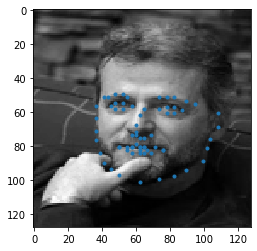

In [251]:
plt.imshow(rsimg,cmap='gray')
plt.scatter(key_pts[:,0]*ry,key_pts[:,1]*rx, marker='.')
plt.show()

In [15]:
model=Sequential()
model.add(conv2d(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu,input_shape=(64,64,1)))
model.add(BatchNormalization())
model.add(dropout(0.1))
model.add(conv2d(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
model.add(BatchNormalization())
model.add(dropout(0.2))
model.add(conv2d(128,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
model.add(BatchNormalization())
model.add(dropout(0.25))
model.add(flatten())
model.add(dropout(0.2))
model.add(dense(256,activation=functions.leakyRelu))
model.add(dense(1,activation=functions.sigmoid))

model.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 64, 64, 3)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 32, 32, 32)         leakyRelu        896
__________________________________________________________________________________________
2 BatchNormalization(Batc (None, 32, 32, 32)         echo             128
__________________________________________________________________________________________
3 dropout(dropout)        (None, 32, 32, 32)         echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 16, 16, 64)         leakyRelu        18496
__________________________________________________________________________________________
5 BatchN

In [161]:
face_cascade = cv2.CascadeClassifier('/usr/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/usr/lib/python3.7/site-packages/cv2/data/haarcascade_eye.xml')

In [9]:
model.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [192]:
gray = cv2.cvtColor(rsimg.astype(np.float32), cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    eye_gray = gray[y:y+h,x:x+w]
    eye_col = img[y:y+h,x:x+w]
    eyes = eye_cascade.detectMultiScale(eye_gray)
    for (x,y,w,h) in eyes:
        cv2.rectangle(eye_col, (x,y), (x+w,y+h),(0,255,0),2)

error: OpenCV(4.1.0) /io/opencv/modules/objdetect/src/cascadedetect.cpp:1360: error: (-215:Assertion failed) scaleFactor > 1 && _image.depth() == CV_8U in function 'detectMultiScale'


In [13]:
ccu=0

In [14]:
def run():
    global ccu,svdnoise
    batch_size=64
    dsz=len(names)
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        # Get random real images
        real_images=get_batch(ccu,batch_size)
        ccu+=batch_size
        if ccu>len(names):
            ccu=0
            break
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Train discriminator
        y_fake=np.random.uniform(0,0.05,(batch_size,1)).astype(np.float32)
        y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
#         err=np.array(0)
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        # backpropogate the generator and update weights
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%40:
            print("\nSaving grid.")
            gen_grid(svdnoise[:25],show=False,save=True)
            gen_sample()
        print("\rProgress: {:.2f} %    {}    Dloss: {}    err: {}    Step time: {:.3f}s    _".format(step*batch_size*100/dsz,ccu,dloss,abs(err).sum(),time()-stt),end='')
    if ccu>len(names):
        ccu=0

In [ ]:
epochs=5
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))